# <center>Обучение без учителя: кластеризация. Отбор соединений для создания диверсифицированного набора молекул (Diverse library)

Кластеризация — это отдельный класс задач машинного обучения, отличающийся от классификации тем, что у объектов обучающей выборки нет заранее заданных ответов учителя.  
Дано:  
Пространство объектов, среди которых конечное множество объектов — это и обучающая выборка и тестовая выборка, и на этих объектах задана функция расстояния, то есть мы знаем расстояние между этими объектами.  
Требуется:  
Найти метки кластеров этих объектов. То есть так разделить конечное множество объектов на группы или кластеры, чтобы близкие объекты оказались внутри каждой группы, а между объектами разных групп расстояния были достаточно большие.  
  
Для чего мы хотим решать такую задачу:  
- упрощение представления о большом количестве объектов;  
- понимание их внутренней структуры, что они всё-таки состоят из каких-то групп однородных объектов;  
- дальше с этими отдельными выделенными группами уже можно делать какой-то анализ, ну и так далее;  
  
В зависимости от специфики задачи и особенностей используемых в задаче данных задачи кластеризации могут сильно отличаться. Может, например, отличаться форма, размер и иерархия кластеров, а также тип задачи (основная или побочная) и тип классификации (жесткая или мягкая).  
  
**Жёсткая или мягкая кластеризация**  
В зависимости от того, может ли относиться объект сразу к нескольким кластерам, бывает:  
 - Жесткая кластеризация: объект может быть отнесен только к одному из кластеров.  
 - Мягкая кластеризация: объект может быть отнесен к нескольким кластерам сразу (с некоторыми весами).  
   

### <center>Различные формы кластеров

Кластеры могут иметь совершенно различную форму:
- В простейшем случае кластеры представляют собой «сгустки точек» и могут быть легко выделены окружностью.
- Иногда кластеры принимают более сложную форму, но все также могут быть легко выделены.
- Возможен случай, когда между кластерами есть такие точки, которые сложно отнести к определенному кластеру.
- Кластеры могут представлять собой вытянутые ленты. В этом случае можно найти пару точек из разных кластеров, которые находятся ближе некоторой пары из одного кластера. Такие кластеры можно выделить, добавляя к строящемуся кластеру близжайшую точку.
- Кластеры могут плавно перетекать друг в друга. В этом случае описанная для предыдущего случая стратегия уже не работает.
- Кластеры могут быть образованы по некоторому закону, который все же не известен.
- Кластеры могут пересекаться. В этом случае достаточно сложно определить, к какому кластеру относятся некоторые объекты.

Также кластеров может вовсе не быть.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import make_classification
from sklearn.cluster import AgglomerativeClustering

from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import BallTree
from sklearn.metrics import DistanceMetric

import random
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

from collections import defaultdict
from numpy import array, zeros_like, linspace
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from math import inf
import csv

from sklearn.datasets import load_iris
from sklearn.cluster import DBSCAN
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

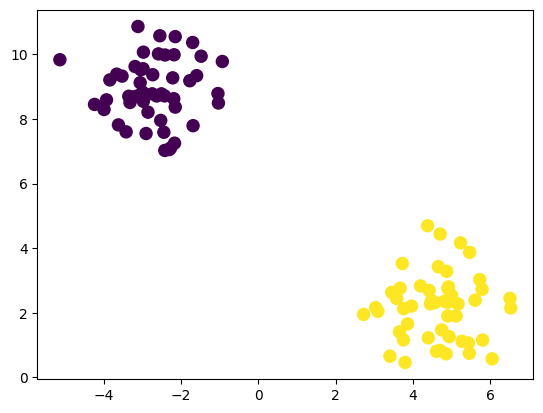

In [2]:
X, y = make_blobs(centers=2, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, s=75);

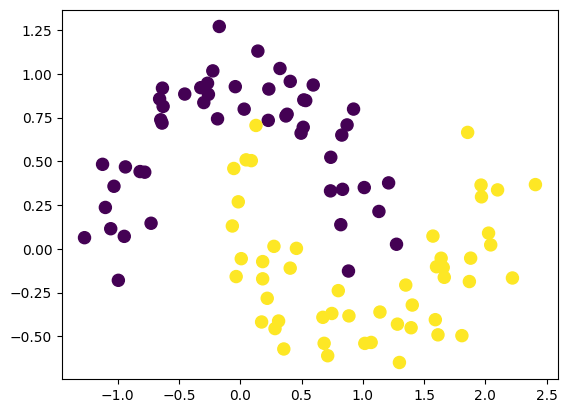

In [3]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, s=75);

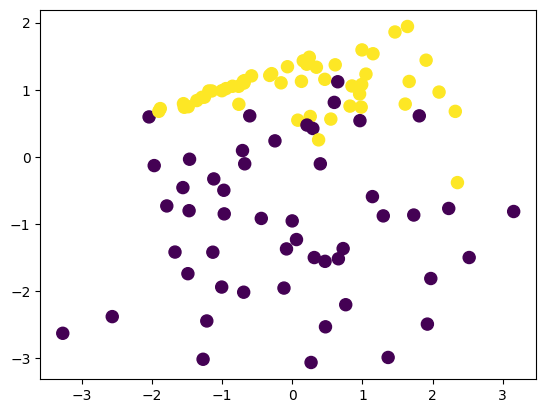

In [4]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, 
                           n_clusters_per_class=2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=75);

## <center>Метод k-средних (k-means)

Метод k-means – это один из наиболее популярных методов кластеризации. В начале работы алгоритма выбираются k случайных точек. Это точки играют роль центров кластеров:
каждая точка будет отнесена к тому кластеру, расстояние до центра которого минимально. После этого выполняются итерации: на каждом шаге в качестве нового центра кластера выбирается среднее арифметическое
всех точек, попавших в этот кластер, и обновляются метки кластеров ля точек в зависимости от близости к
новым центрам кластеров. Итерации выполняются, пока не будет получен удовлетворительный результат.

**Более формально**, алгоритм принимает на вход выборку $X_1, \dots, X_N$ и параметр $k$, указывающий необходимое число кластеров. Выходом алгоритма является набор из $k$ центроидов $\{\mu_1, \dots, \mu_k\}$, с помощью которых кластеризация осуществляется путём отнесения каждого объекту к ближайшему центроиду. Все точки внутри одного кластера ближе к центроиду этого кластера, чем к центроиду любого другого кластера.

Метод может быть сформулирован как **задача оптимизации**, а именно, минимизации суммарного квадратичного отклонения точек кластеров от центров этих кластеров по центроидам и кластерам:
$$\sum_{i=1}^k \sum_{X_n \in C_i} ||X_n - \mu_i||^2 \rightarrow \min, \text{где $C_i$ - это $i$-ый кластер, $\mu_i$ - это центр масс кластера $C_i$.}$$

Решение такой задачи оптимизации является NP-трудной задачей, однако существует простой итеративный алгоритм, позволяющий найти локальный минимум указанного функционала. Алгоритм представляет собой последовательное чередование двух шагов до сходимости. 

Предположим, что как-то (например, случайно) выбраны начальные положения центроидов $\mu_1, \dots, \mu_k$.

1) *Этап кластеризациu.* На данном этапе происходит кластеризация выборки, как было описано выше: каждый объект относится к кластеру ближайшего к нему центроида. Формально, $$C_i = \{X_n : ||X_n - \mu_i|| \leq ||X_n - \mu_j||, \text{ для всех $j \in \{1, \dots, k\}$}\}.$$

2) *Этап обновления центроидов.* На данном этапе центроиды пересчитываются, как центры масс только что построенных кластеров. Формально, $$\mu_i = \frac{1}{|C_i|}\sum_{X_n \in C_i} X_n.$$

Этот процесс продолжается, пока центроиды и кластеризация продолжают изменяться. 
Алгоритм гарантированно сходится, **однако не гарантируется достижение глобального минимума – а только одного из локальных минимумов**. Другим недостатком алгоритма является то, что **итоговая кластеризация зависит от выбора исходных центров кластеров** (параметрическая модель). На практике алгоритм запускается несколько раз из различных начальных приближений, а полученные результаты некоторым образом усредняются. **Стоит также отметить, что число кластеров необходимо знать заранее. Существуют различные эвристики, позволяющие выбирать в некотором смысле оптимальное число кластеров**. [1]

Ниже представлены дескрипторы растворителей, полученные экспериментально.  
Каждый растворитель был описан 13 дескрипторами, как предложено в статье [2], которые характеризуют 
- полярность, 
- поляризуемость, 
- H-кислотность 
- основность,
- постоянные Каталана,
- постоянные Камлета-Тафта, 
- четыре функции в зависимости от диэлектрической проницаемости, 
- три функции в зависимости от показателя преломления.

In [5]:
data = dict((
    ('1-phenylethan-1-one', (.31, .237, .845, .943, .458, .891, .109, .04, .49, .9, .9, .37, .04)),
    ('1,2-dichloroethane', (.266, .21, .757, .903, .431, .824, .091, .0, .1, .81, .89, .13, .03)),
    ('1,2-dimethoxyethane', (.23, .19, .67, .86, .4, .76, .08, .0, .41, .53, .79, .64, .0)),
    ('propane-1,2,3-triol', (.28, .22, .94, .98, .48, .96, .11, 1.21, .51, .62, .95, .31, .65)),
    ('1,3-dimethylbenzene', (.293, .226, .318, .583, .241, .412, .055, .0, .11, .47, .62, .16, .0)),
    ('1,3,5‐trimethylbenzene', (.294, .227, .318, .583, .241, .412, .055, .0, .13, .41, .58, .19, .0)),
    ('1,4-dioxane', (.253, .202, .287, .548, .223, .377, .045, .0, .37, .49, .7, .44, .0)),
    ('2-methylbutan-2-ol', (.245, .197, .614, .827, .381, .705, .075, .28, .93, .4, .83, .94, .1)),
    ('2-methylpropan-1-ol', (.24, .194, .84, .94, .456, .887, .088, .79, .84, .4, .83, .83, .31)),
    ('2-methylpropan-2-ol', (.234, .19, .793, .92, .442, .852, .084, .42, .93, .41, .83, .93, .15)),
    ('2,2,4-trimethylpentane', (.237, .191, .242, .49, .195, .324, .037, .0, .0, .04, .53, .04, .0)),
    ('3-methylbutan-1-ol', (.245, .197, .825, .934, .452, .876, .089, .84, .86, .4, .81, .86, .32)),
    ('acetic acid', (.226, .184, .632, .837, .387, .72, .071, 1.12, .45, .64, .78, .39, .69)),
    ('acetonitrile', (.21, .174, .921, .972, .479, .946, .083, .19, .4, .66, .9, .29, .04)),
    ('benzene', (.293, .227, .297, .559, .229, .388, .052, .0, .1, .55, .67, .12, .0)),
    ('benzenecarbonitrile', (.31, .24, .89, .96, .47, .93, .11, .0, .37, .9, .96, .28, .05)),
    ('bromobenzene', (.323, .244, .595, .815, .373, .688, .091, .0, .06, .79, .82, .19, .0)),
    ('butan-1-ol', (.241, .194, .846, .943, .458, .892, .089, .84, .84, .47, .84, .81, .34)),
    ('butan-2-ol', (.24, .193, .838, .94, .456, .886, .088, .69, .8, .4, .84, .89, .22)),
    ('butan-2-one', (.23, .187, .851, .945, .46, .895, .086, .06, .48, .6, .88, .52, .0)),
    ('chlorobenzene', (.304, .233, .606, .822, .377, .698, .088, .0, .07, .68, .82, .18, .0)),
    ('cyclohexane', (.255, .203, .254, .505, .202, .338, .041, .0, .0, .0, .56, .07, .0)),
    ('dichloromethane', (.254, .202, .726, .888, .42, .799, .085, .13, .1, .82, .88, .18, .04)),
    ('ethane-1,2-diol', (.259, .205, .924, .973, .48, .948, .099, .9, .52, .92, .93, .53, .72)),
    ('ethanol', (.22, .181, .887, .959, .47, .922, .085, .86, .75, .54, .85, .66, .4)),
    ('ethoxybenzene', (.3, .23, .52, .76, .34, .62, .08, .0, .3, .69, .74, .3, .0)),
    ('ethoxyethane', (.215, .177, .516, .762, .34, .615, .06, .0, .47, .24, .69, .56, .0)),
    ('ethyl acetate', (.228, .19, .63, .83, .38, .72, .071, .0, .45, .55, .8, .54, .0)),
    ('ethyl benzoate', (.297, .229, .625, .833, .385, .714, .088, .0, .41, .74, .84, .42, .0)),
    ('formamide', (.267, .211, .973, .991, .493, .982, .104, .71, .48, .97, .83, .41, .55)),
    ('deuterium oxide', (.203, .169, .963, .987, .49, .975, .083, 1.17, .47, 1.09, .96, .44, 1.06)),
    ('heptan-1-ol', (.255, .203, .775, .912, .437, .838, .089, .79, .82, .4, .8, .91, .3)),
    ('heptane', (.236, .19, .235, .479, .19, .315, .036, .0, .0, -.08, .53, .08, .0)),
    ('hexamethylphosphoramide', (.277, .217, .906, .967, .475, .935, .103, .0, 1.05, .87, .93, .81, .0)),
    ('hexan-1-ol', (.251, .201, .804, .925, .446, .86, .089, .8, .84, .4, .81, .88, .32)),
    ('hexane', (.227, .185, .227, .468, .185, .306, .034, .0, .0, -.11, .52, .06, .0)),
    ('methanedithione', (.355, .262, .348, .615, .258, .444, .068, .0, .07, .61, .59, .1, .0)),
    ('methanesulfinylmethane', (.283, .22, .938, .978, .484, .958, .107, .0, .76, 1.0, 1.0, .65, .07)),
    ('methanol', (.202, .168, .913, .969, .477, .941, .08, .98, .66, .6, .86, .55, .61)),
    ('methoxybenzene', (.3, .23, .52, .77, .34, .62, .08, .0, .32, .73, .82, .3, .08)),
    ('N,N-dimethylacetamide', (.26, .21, .92, .97, .48, .95, .1, .0, .76, .88, .97, .61, .03)),
    ('N,N-dimethylformamide', (.257, .205, .923, .973, .48, .947, .098, .0, .69, .88, .95, .61, .03)),
    ('nitrobenzene', (.319, .242, .918, .971, .479, .944, .116, .0, .3, .86, .97, .24, .06)),
    ('nitromethane', (.231, .188, .921, .972, .479, .946, .09, .22, .06, .75, .91, .24, .08)),
    ('octan-1-ol', (.257, .204, .757, .903, .431, .824, .088, .77, .81, .4, .79, .92, .3)),
    ('oxolan-2-one', (.26, .207, .927, .974, .481, .95, .099, .0, .49, .85, .99, .4, .06)),
    ('1,4-epoxybutane', (.245, .197, .687, .868, .407, .767, .08, .0, .55, .55, .84, .59, .0)),
    ('1,4-dimethylbenzene', (.29, .226, .302, .565, .232, .394, .052, .0, .12, .43, .62, .16, .0)),
    ('pentan-1-ol', (.247, .198, .811, .928, .448, .866, .089, .84, .86, .4, .82, .86, .32)),
    ('phenylmethanol', (.313, .238, .796, .921, .443, .854, .106, .6, .52, .98, .89, .46, .41)),
    ('piperidine', (.27, .213, .62, .83, .383, .71, .081, .0, 1.04, .3, .74, .93, .0)),
    ('propan-1-ol', (.234, .189, .866, .951, .464, .907, .088, .84, .9, .52, .85, .78, .37)),
    ('propan-2-ol', (.229, .186, .863, .95, .463, .904, .086, .76, .84, .48, .85, .83, .28)),
    ('propan-2-one', (.218, .179, .867, .951, .464, .907, .083, .08, .48, .62, .88, .48, .0)),
    ('propanenitrile', (.222, .182, .901, .965, .474, .932, .086, .0, .37, .64, .88, .37, .03)),
    ('pyridine', (.298, .229, .799, .923, .444, .856, .102, .0, .64, .87, .92, .58, .03)),
    ('tetrachloromethane', (.272, .214, .292, .554, .226, .383, .048, .0, .1, .21, .63, .04, .0)),
    ('tetrahydrothiophene 1,1-dioxide', (.285, .222, .934, .977, .483, .955, .107, .0, .39, .9, 1.0, .37, .05)),
    ('toluene', (.291, .226, .315, .58, .24, .408, .054, .0, .11, .49, .66, .13, .0)),
    ('trichloromethane', (.265, .209, .565, .796, .361, .66, .076, .2, .1, .58, .79, .07, .05)),
    ('water', (.205, .17, .963, .987, .49, .975, .084, 1.17, .47, 1.09, .96, .03, 1.06))))

In [6]:
df = pd.DataFrame(data, index=['polarizability_form1',
                               'polarizability_form2', 
                               'permettivity_form1', 
                               'permettivity_form2',
                               'permettivity_form3', 
                               'permettivity_form4', 
                               'permettivity_polarizability', 
                               'alpha_kamlet-taft',
                               'beta_Kamlet-Taft', 
                               'pi*_Kamlet-taft', 
                               'SPP_Katalan', 
                               'SB_Katalan', 
                               'SA_Katalan']).T

In [7]:
df.head()

,polarizability_form1,polarizability_form2,permettivity_form1,permettivity_form2,permettivity_form3,permettivity_form4,permettivity_polarizability,alpha_kamlet-taft,beta_Kamlet-Taft,pi*_Kamlet-taft,SPP_Katalan,SB_Katalan,SA_Katalan
1-phenylethan-1-one,0.310,0.237,0.845,0.943,0.458,0.891,0.109,0.04,0.49,0.90,0.90,0.37,0.04
"1,2-dichloroethane",0.266,0.210,0.757,0.903,0.431,0.824,0.091,0.00,0.10,0.81,0.89,0.13,0.03
"1,2-dimethoxyethane",0.230,0.190,0.670,0.860,0.400,0.760,0.080,0.00,0.41,0.53,0.79,0.64,0.00
"propane-1,2,3-triol",0.280,0.220,0.940,0.980,0.480,0.960,0.110,1.21,0.51,0.62,0.95,0.31,0.65
"1,3-dimethylbenzene",0.293,0.226,0.318,0.583,0.241,0.412,0.055,0.00,0.11,0.47,0.62,0.16,0.00


In [8]:
# Подготовим данные для работы
Y = df.index.values
X = df.values

In [9]:
# Метод кластеризации по соседям
km = KMeans(n_clusters=3, random_state=42).fit(X)  # обучение модели

e:\miniconda3\envs\ds\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "e:\miniconda3\envs\ds\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "e:\miniconda3\envs\ds\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\miniconda3\envs\ds\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "e:\miniconda3\envs\ds\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
  

In [10]:
y_pred = km.predict(X)  # предсказание номеров кластеров

Продемонстрируем кластеры и объекты в них попавшие

In [11]:
clusters = defaultdict(list)
for o, p in zip(Y, y_pred):
    clusters[p].append(o)
for p, o in clusters.items():
    print(p, o)

0 ['1-phenylethan-1-one', '1,2-dichloroethane', '1,2-dimethoxyethane', 'acetonitrile', 'benzenecarbonitrile', 'bromobenzene', 'butan-2-one', 'chlorobenzene', 'dichloromethane', 'ethoxybenzene', 'ethyl acetate', 'ethyl benzoate', 'hexamethylphosphoramide', 'methanesulfinylmethane', 'methoxybenzene', 'N,N-dimethylacetamide', 'N,N-dimethylformamide', 'nitrobenzene', 'nitromethane', 'oxolan-2-one', '1,4-epoxybutane', 'piperidine', 'propan-2-one', 'propanenitrile', 'pyridine', 'tetrahydrothiophene 1,1-dioxide']
1 ['propane-1,2,3-triol', '2-methylbutan-2-ol', '2-methylpropan-1-ol', '2-methylpropan-2-ol', '3-methylbutan-1-ol', 'acetic acid', 'butan-1-ol', 'butan-2-ol', 'ethane-1,2-diol', 'ethanol', 'formamide', 'deuterium oxide', 'heptan-1-ol', 'hexan-1-ol', 'methanol', 'octan-1-ol', 'pentan-1-ol', 'phenylmethanol', 'propan-1-ol', 'propan-2-ol', 'water']
2 ['1,3-dimethylbenzene', '1,3,5‐trimethylbenzene', '1,4-dioxane', '2,2,4-trimethylpentane', 'benzene', 'cyclohexane', 'ethoxyethane', 'hept

**Вычислим дистанции до центров кластеров**

In [12]:
Xclust = km.transform(X)
Xclust[:3]

array([[0.20213874, 1.01858417, 1.13969607],
       [0.46402594, 1.26686089, 0.90952146],
       [0.35639907, 1.02337683, 0.86199188]])

Найдем наиболее представительные элементы кластеров

In [13]:
cl = [(0, inf)] * Xclust.shape[1]
for m, i in enumerate(Xclust):
    for n, (j, (_, c)) in enumerate(zip(i, cl)):
        if j < c:
            cl[n] = (m, j)
cl = [x for x, _ in cl]
for n, i in enumerate(cl):
    print(n, Y[i])

0 propan-2-one
1 ethanol
2 1,3,5‐trimethylbenzene


In [14]:
pc = PCA(n_components=2).fit(X)
X2 = pc.transform(X) # исходные данные
X2C = pc.transform(km.cluster_centers_) # центры кластеров
X2N = X2[cl] # наиболее представительные

In [15]:
X2N

array([[-0.01134117, -0.34500953],
       [ 0.71128391,  0.24366545],
       [-0.81688238,  0.24869977]])

 Визулизация исходных данных с маркировкой по кластерам

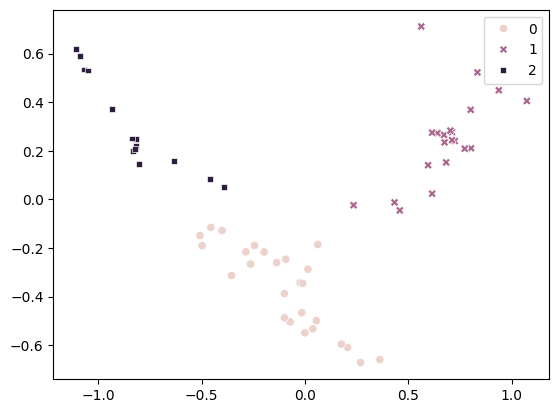

In [16]:
sns.scatterplot(x=X2[:, 0], y=X2[:, 1], hue=y_pred, style=y_pred);

Добавим на карту центры кластеров (зеленые точки) и обозначим представительные объекты (синие)

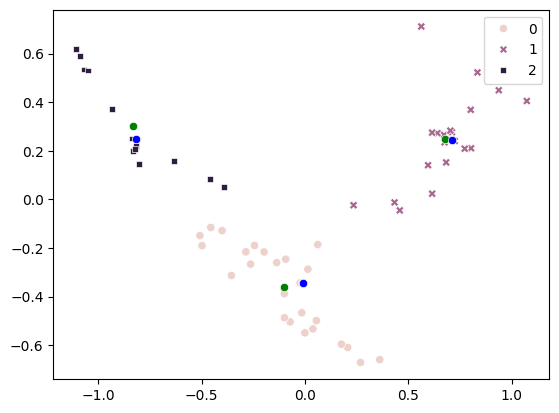

In [17]:
sns.scatterplot(x=X2[:, 0], y=X2[:, 1], hue=y_pred, style=y_pred)
sns.scatterplot(x=X2C[:, 0], y=X2C[:, 1], color='g')
sns.scatterplot(x=X2N[:, 0], y=X2N[:, 1], color='b');

### Начальное приближение. Инициализация центроидов

Метод `sklearn.KMeans` содержит параметры `n_init` (число запусков из различных начальных приближений) и `init`. Есть три способа инициализации центроидов:
- `k-means++` – "умная" инициализация центроидов для ускорения сходимости.
- `random` – случайная инициализация центроидов.
- `ndarray` – заданная инициализация центроидов.

Также стоит заметить, что хоть мы и рассматривали евклидово расстояние, алгоритм будет сходиться и в случае любой другой метрики, поэтому для различных задач кластеризации в зависимости от данных можно экспериментировать не только с количеством шагов или критерием сходимости, но и с метрикой, по которой мы считаем расстояния между точками и центроидами кластеров.

Другой особенностью этого алгоритма является то, что он чувствителен к исходному положению центроид кластеров в пространстве. В такой ситуации спасает несколько последовательных запусков алгоритма с последующим усреднением полученных кластеров.

### Выбор числа кластеров для kMeans

В отличие от задачи классификации или регресии, в случае кластеризации сложнее выбрать критерий, с помощью которого было бы просто представить задачу кластеризации как задачу оптимизации.
В случае kMeans распространен вот такой критерий – сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся.
$$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

здесь $C$ – множество кластеров мощности $K$, $\mu_k$ – центроид кластера $C_k$.

Понятно, что здравый смысл в этом есть: мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого фнукционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента).
Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: 
$$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Рассмотрим пример.

In [18]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

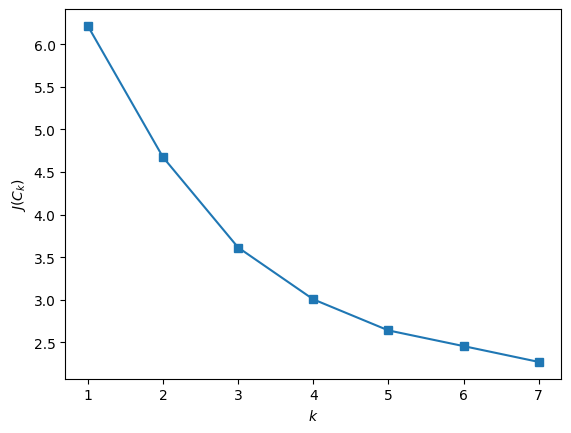

In [19]:
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Видим, что $J(C_k)$ падает сильно при увеличении числа кластеров с 1 до 2 и с 2 до 3 и уже не так сильно – при изменении $k$ с 3 до 4. Значит, в данной задаче оптимально задать 3 кластера.  

#### Сложности

Само по себе решение задачи K-means NP-трудное (NP-Hard, [статья](https://habrahabr.ru/post/132127/) "Еще немного про P и NP" на Хабре), и для размерности $d$, числа кластеров $k$ и числа точек $n$ решается за $O(n^{d k+1})$. Для решения такой боли часто используются эвристики, например MiniBatch K-means, который для обучения использует не весь датасет целиком, а лишь маленькие его порции (batch) и обновляет центроиды используя среднее за всю историю обновлений центроида от всех относящихся к нему точек. Сравнение обычного K-means и его MiniBatch имплементации можно посмотреть в [документации scikit-learn](http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html).

[Реализация](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) алгоритма в scikit-learn обладает массой удобных плюшек, таких как возможность задать количество запусков через параметр `n_init`, что даст более устойчивые центроиды для кластеров в случае скошенных данных. К тому же эти запуски можно делать параллельно, не жертвуя временем вычисления.

## <center> Агломеративная кластеризация

Наверное, самый простой и понятный алгоритм кластеризации без фиксированного числа кластеров — агломеративная кластеризация. Алгоритм очень простой и интуитивно понятный: 
- В начале каждая точка относится к своему собственному кластеру. 
- На каждом шаге алгоритма те кластеры, расстояние между которыми минимально, объединяются в один. 
- Постепенно все кластеры объединяются в один, а процесс их объединения представляет собой дерево. 
- Его можно изобразить с помощью так называемых дендрограмм. По горизонтальной оси дендрограммы отложено расстояние между кластерами в момент слияния, а по вертикальной — точки выборки.

Сам процесс поиска ближайших кластеров может происходить с использованием разных методов объединения точек:
1. Single linkage — минимум попарных расстояний между точками из двух кластеров
$d(C_i, C_j) = min_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$
2. Complete linkage — максимум попарных расстояний между точками из двух кластеров
$d(C_i, C_j) = max_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$
3. Average linkage — среднее попарных расстояний между точками из двух кластеров
$d(C_i, C_j) = \frac{1}{n_i n_j} \sum_{x_i \in C_i} \sum_{x_j \in C_j} ||x_i - x_j||$
4. Centroid linkage — расстояние между центроидами двух кластеров
$d(C_i, C_j) = ||\mu_i - \mu_j||$

Профит первых трёх подходов по сравнению с четвёртым в том, что для них не нужно будет пересчитывать расстояния каждый раз после склеивания, что сильно снижает вычислительную сложность алгоритма.

По итогам выполнения такого алгоритма можно также построить замечательное дерево склеивания кластеров и глядя на него определить, на каком этапе нам было бы оптимальнее всего остановить алгоритм. Либо воспользоваться тем же правилом локтя, что и в k-means.

К счастью для нас, в питоне уже есть замечательные инструменты для построения таких дендрограмм для агломеративной кластеризации. Рассмотрим на примере наших кластеров из K-means:

In [20]:
model = AgglomerativeClustering(n_clusters=3, linkage='complete')
preds = model.fit_predict(X)

In [21]:
preds

array([1, 1, 1, 0, 2, 2, 2, 1, 0, 1, 2, 0, 0, 1, 2, 1, 1, 0, 0, 1, 1, 2,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 2, 0, 0, 1, 0, 0, 1, 1, 1, 2, 1, 2, 1, 0], dtype=int64)

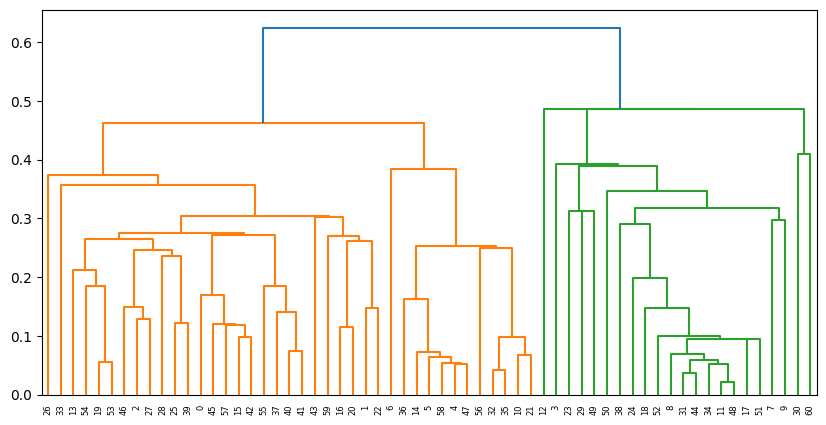

In [22]:
distance_mat = pdist(X) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'single') # linkage — реализация агломеративного алгоритма
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

- Иерархическая кластеризация хуже подходит для кластеризации больших объемов данных в сравнении с методом k-средних. Это объясняется тем, что временная сложность алгоритма линейна для метода k-средних (O(n)) и квадратична для метода иерархической кластеризации (O(n2))
- В кластеризации при помощи метода k-средних алгоритм начинает построение с произвольного выбора начальных точек, поэтому, результаты, генерируемые при многократном запуске алгоритма, могут отличаться. В то же время в случае иерархической кластеризации результаты воспроизводимы.
- Из центроидной геометрии построения метода k-средних следует, что метод хорошо работает, когда форма кластеров является гиперсферической (например, круг в 2D или сфера в 3D).
- Метод k-средних более чувствителен к зашумленным данным, чем иерархический метод.

***Другие методы кластеризации:***

<img src='pictures/picture_3.jpg'>

Как можно увидеть на данной иллюстрации, на сегодняшний день из методов, представленных в sklearn, лучшее качество кластеризации для большинства датасетов показывают методы DBSCAN, AgglomerativeClustering и OPTICS. Наибольшую популярность среди Data Scientists приобрел метод DBSCAN.

## <center> Методы, основанные на плотности точек. DBSCAN

Существуют так называемые методы, основанные на плотности точек (density-based), которые используют
следующую идею. Для каждой точки выборки рассматривается её окрестность, причем:
- Точка называется ***основной***, если в ее окрестности много других точек (больше, чем некоторое число).
- Точка называется ***пограничной***, если в ее окрестности мало других точек, но среди них есть основная.
- В ином случае точка называется ***шумовой***.

DBSCAN (Density-Based Spatial Clustering of Applications with Noise, плотностной алгоритм пространственной кластеризации с присутствием шума) – популярный алгоритм кластеризации, используемый в анализе данных в качестве одной из замен метода k-средних.

Метод не требует предварительных предположений о числе кластеров, но нужно настроить два других параметра: eps и min_samples. Данные параметры – это соответственно максимальное расстояние между соседними точками и минимальное число точек в окрестности (количество соседей), когда можно говорить, что эти экземпляры данных образуют один кластер. В scikit-learn есть соответствующие значения параметров по умолчанию, но, как правило, их приходится настраивать самостоятельно.

DBSCAN — это один из density-based методов, который состоит из следующих шагов:
1. Разделить точки на основные, пограничные и шумовые.
2. Отбросить шумовые точки.
3. Соединить основные точки, которые находятся на расстоянии ε друг от друга.
4. Каждую группу соединенных основных точек объединить в свой кластер.
5. Отнести пограничные точки к соответствующим им кластерам.

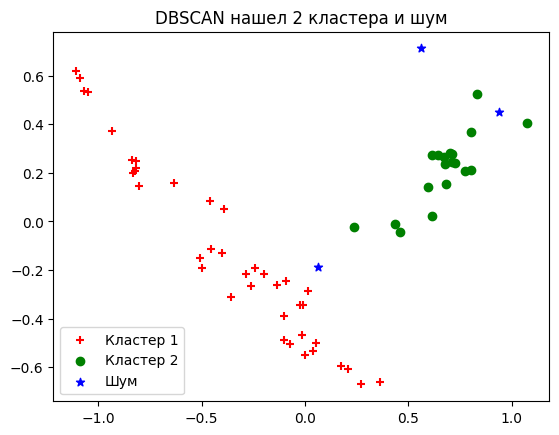

In [23]:
# Определяем модель
dbscan = DBSCAN()

# Обучаем
dbscan.fit(X)

# Уменьшаем размерность при помощи метода главных компонент
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)

# Строим в соответствии с тремя классами
for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='o')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='b', marker='*')

plt.legend([c1, c2, c3], ['Кластер 1', 'Кластер 2', 'Шум'])
plt.title('DBSCAN нашел 2 кластера и шум')
plt.show()

In [24]:
dbscan.labels_

array([ 0,  0,  0,  1,  0,  0,  0,  1,  1,  1,  0,  1, -1,  0,  0,  0,  0,
        1,  1,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  1,  1,  1,  0,  0,
        1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  1, -1,
        1,  1,  0,  0,  0,  0,  0,  0,  0, -1], dtype=int64)

## <center> Отбор соединений для создания диверсифицированного набора молекул (Diverse library)

**_Цель:_** создать диверсифицированный набор соединений (diverse library)

## Подготовка данных:

In [25]:
suppl = Chem.SmilesMolSupplier('data/Set_1100.smiles', titleLine=False) #читаем из файла, содержащего SMILES
molecules = [x for x in suppl if x is not None] # формируем из прочтенного список адекватно прочитанных молекул
activity = [0 if i < 1000 else 1 for i in range(1100)]   # Файл, прочтенный выше, был сформирован таким образом, что первые 1000 соединений 
           # - неактивные, оставшиеся 100 - активные. Запишем информацию об активности 
           # молекул в список (0 соответствует неактивной молекуле, 1 - активной)

[17:30:26] WARNING: no name column found on line 0
[17:30:26] WARNING: no name column found on line 1
[17:30:26] WARNING: no name column found on line 2
[17:30:26] WARNING: no name column found on line 3
[17:30:26] WARNING: no name column found on line 4
[17:30:26] WARNING: no name column found on line 5
[17:30:26] WARNING: no name column found on line 6
[17:30:26] WARNING: no name column found on line 7
[17:30:26] WARNING: no name column found on line 8
[17:30:26] WARNING: no name column found on line 9
[17:30:26] WARNING: no name column found on line 10
[17:30:26] WARNING: no name column found on line 11
[17:30:26] WARNING: no name column found on line 12
[17:30:26] WARNING: no name column found on line 13
[17:30:26] WARNING: no name column found on line 14
[17:30:26] WARNING: no name column found on line 15
[17:30:26] WARNING: no name column found on line 16
[17:30:26] WARNING: no name column found on line 17
[17:30:26] WARNING: no name column found on line 18
[17:30:26] WARNING: no

In [26]:
# Произведем расчет дескрипторов. В данном случае выбрали молекулярные отпечатки Моргана [3], 
# представленные в виде битовых строк.
molFingerprints = []
for mol in molecules:
    AllChem.Compute2DCoords(mol)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024) # для каждой молекулы рассчитываем молекулярный 
    molFingerprints.append(fp)                                   # отпечаток, для этого передаем даннной функции молекулу,
                                                                 # используемый для расчета радиус окружения[3] 
                                                                 # и длину битовой строки

[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerator
[17:30:27] DEPRECATION WARNING: please use MorganGenerat

### Отбор молекул для создания диверсифицированной выборки

#### Способ 1. Отбираем молекулы случайным образом

In [27]:
def random_subset_generation(seed):
    random.seed(seed)                       # seed настраивает генератор случайных чисел на новую последовательность [4].
    set_num = [x for x in range(0,1099,1)]  # создаем список чисел от 0 до 1099, каждое из которых будет соответствовать  
                                            # индексу молекулы в molecules, соответствующему этой молекуле индексу  
                                            # молекулярного отпечатка в molFingerprints и индексу значения ее активности 
                                            # в activity
    random_subset = random.sample(set_num,110)  # извлекаем из списка set_num 110 случайных чисел
                                                # в итоге мы получаем список индексов молекул, формирующих диверсифицированную
                                                # выборку, отобранную случайным образом
    return random_subset

#### Способ 2. Отбираем молекулы с использованием агломеративной иерархической кластеризации

In [28]:
def generation_cluster_subset(seed,atype): 
    clustering = AgglomerativeClustering(linkage=atype, metric='jaccard',n_clusters=110) # создаем экземпляр класса
                            # AgglomerativeClustering[5] со следующими важными для нас параметрами: linkage - это метод,
                            # который мы будем использовать для расчета расстояний между кластерами (в данном случае
                            # этот параметр мы получаем как аргумент нашей функции)[6], metric - используемая метрика
                            # - здесь выбрана метрика Жаккарда, равная 1-индекс Танимото, т.к. в качестве дескрипторов
                            # мы используем битовые строки (подробнее о зависимости выбора метрики от типа дескрипторов
                            # см. [7]), n_clusters - количество кластеров, на которые будут делиться молекулы. В данном
                            # случае мы делим молекулы на 110 групп, чтобы в дальнейшем из каждой группы отобрать 
                            # по 1 молекуле.
    x = np.array(molFingerprints)
    result = clustering.fit_predict(x)# Выполняется кластеризация молекулярных отпечатков, в качестве результата
                                      # получаем список, содержащий метки кластера для каждой молекулы.
    clusters = defaultdict(list)      # Создаем defaultdict [8], где указываем, что каждому ключу будет соответствовать 
                                      # список значений.
    for i,cluster in enumerate(result):   # Формируем словарь, где в качестве ключей выступают номера кластеров, а в 
        clusters[cluster].append(i)       # качестве значений - список индексов молекул, попавших в соответствующие 
                                          # кластеры.
    clust_subset =[]                    # Это будет итоговый список индексов отобранных молекул  
    for clust,ids in clusters.items():     # Из каждого кластера отберем по одной молекуле
        instance = center_cluster(ids,x)   # Отбирать будем самые представительные для кластера молекулы - т.е. 
                                           # находящиеся в центре кластера. Для этого напишем функцию (см. ниже), 
                                           # в которую в качестве аргументов передадим список индексов молекул,
                                           # относящихся к текущему кластеру, и список молекулярных отпечатков Моргана
                                           # для всех исходных молекул. Эта функция возвращает положение индекса самой
                                           # представительной молекулы кластера в списке ids (т.е. в списке индексов 
                                           # молекул, относящихся к текущему кластеру)
        clust_subset.append(ids[instance]) # Добавляем индекс отобранной молекулы в выборку
    return clust_subset 

In [29]:
def center_cluster(ids,x):                        # функция отбора молекулы, находящейся в центре кластера, т.е. такой,
                                                  # для которой сумма расстояний до остальных молекул кластера минимальна.
    subset = x[ids,:]                               # из общего списка молекулярных отпечатков Моргана извлекаем те,
                                                  # которые соответствуют индексам молекул, относящихся к текущему кластеру
    dist = DistanceMetric.get_metric('jaccard')   # Получаем метрику расстояния Жаккарда (1-индекс Танимото)
    distance_matrix = dist.pairwise(subset)       # Для каждой пары молекулярных отпечатков рассчитываем расстояние.
                                                  # Как результат, получаем матрицу расстояний между молекулами для 
                                                  # текущего кластера.
    res = np.argmin(sum(distance_matrix))         # Суммируем расстояния по столбцам и получаем положение минимального
                                                  # значения суммы расстояний.
    return res

#### Способ 3. Отбираем молекулы с использованием метода сфер исключения (sphere_exclusion)

In [30]:
def generation_sphere_exclusion_subset(seed): # О методе сфер исключения (sphere_exclusion) подробнее см. [9]
    random.seed(a=seed)
    s_exclusion_subset = []
    X = np.array(molFingerprints)
    tree = BallTree(X, metric='jaccard')      # Для рассчета расстояний до ближайших соседей испольуем метод BallTree[10]
                                              # В качестве метрики расстояния используем метрику Жаккарда (1 - индекс Танимото)
    set_num = [x for x in range(0,1099,1)]
    radius = 0.5                              # Определяем радиус сферы исключения.
    while len(s_exclusion_subset) < 110:      # Мы хотим получить 110 кластеров
        id_mol = random.sample(set_num,1)         # Случайным образом выбираем индекс молекулы из списка set_num
        instance = X[id_mol]                      # Извлекаем молекулярный отпечаток Моргана этой молекулы
        to_del = tree.query_radius(instance,r=radius) # В новый список добавляем эту молекулу и всех ее соседей ("список на удаление")
        s_exclusion_subset.append(id_mol[0])      # Добавляем отобранную молекулу в итоговый список
        for ind in to_del[0]:                 # Удаляем из списка set_num индексы отобранной молекулы и всех ее соседей
            if ind in set_num:
                set_num.remove(ind)
    return s_exclusion_subset

### Расчет среднего количества активных соединений из выборки

In [31]:
def average_num_act(my_func,num_repeat, *args): # В качестве аргументов передаем название метода генерации выборки, 
                                               # число повторений и дополнительный аргумент (используется в случае 
                                               # агломеративной кластеризации)
    itog = []                                  # список количества активных соединений, найденных в выборке после каждого
                                               # из повторений
    while num_repeat > 0:                      
        subset = my_func(num_repeat, *args)
        subset_num_act = 0                     # счетчик количества активных соединений
        for i in subset:
            if activity[i] == 1:
                subset_num_act += 1
        itog.append(subset_num_act)
        num_repeat -= 1
    result = sum(itog)/len(itog)               # усредняем количество активных соединений
    return result

### Запуск расчетов и результаты

In [32]:
header = [
    'Repeating', 
    'Random Subset (%)', 
    'Average-Link Clusterization (%)', 
    'Complete-Link Clusterization (%)', 
    'Sphere Exclusion (%)', 
    'Initial Dataset (%)'
]

results = []

In [33]:
for repeating in [10, 15, 25, 50, 100]:
    av_r_sub = average_num_act(random_subset_generation, repeating)               # для каждого из выше рассмотренных методов отбора
    av_clust_sub1 = average_num_act(generation_cluster_subset, 1, 'average') # молекул устанавливаем среднее количество активных соединений
    av_clust_sub2 = average_num_act(generation_cluster_subset, 1, 'complete') # в качестве аргументов передаем название функции, генерирующей 
    av_sph_exc_sub = average_num_act(generation_sphere_exclusion_subset, repeating) # диверсифицированный набор молекул и количество повторений
    ratio_act_r_sub = (av_r_sub / 110) * 100                     # рассчитываем средний процент активных соединений для каждого
    ratio_act_clust_sub1 = (av_clust_sub1 / 110) * 100           # метода отбора
    ratio_act_clust_sub2 = (av_clust_sub2 / 110) * 100
    ratio_act_exc_sub = (av_sph_exc_sub / 110) * 100
    # print(f"ratio of active molecules to inactive in random subset = {round(ratio_act_r_sub,1)}%")
    # print(f"ratio of active molecules to inactive in subset after average-link clusterization = {round(ratio_act_clust_sub1,1)}%")
    # print(f"ratio of active molecules to inactive in subset after complete-link clusterization = {round(ratio_act_clust_sub2,1)}%")
    # print(f"ratio of active molecules to inactive in subset after sphere exclusion = {round(ratio_act_exc_sub,1)}%")
    # print(f"ratio of active molecules to inactive in initial dataset = {round((100/1100)*100)}%")
    results.append([
    repeating, 
    round(ratio_act_r_sub, 1),
    round(ratio_act_clust_sub1, 1),
    round(ratio_act_clust_sub2, 1),
    round(ratio_act_exc_sub, 1),
    round((100/1100)*100)
])

In [34]:
with open('results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header) 
    writer.writerows(results)

In [35]:
pd.read_csv("results.csv")

,Repeating,Random Subset (%),Average-Link Clusterization (%),Complete-Link Clusterization (%),Sphere Exclusion (%),Initial Dataset (%)
0,10,9.9,6.4,6.4,9.7,9
1,15,9.5,6.4,6.4,9.7,9
2,25,9.3,6.4,6.4,9.9,9
3,50,9.3,6.4,6.4,9.9,9
4,100,9.0,6.4,6.4,9.8,9
